# **Phase 1: Check and Install Libraries/Dependecies**

In [2]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   4
  On-line CPU(s) list:    0-3
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   2
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.32
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

In [3]:
!pip install pytorch-tsmixer
!pip install --upgrade scikit-learn imbalanced-learn
!pip install shap
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [4]:
import os
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pprint as pp
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from torchtsmixer import TSMixer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
import shap
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from datetime import datetime

warnings.filterwarnings('ignore')

In [5]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [6]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# **Phase 2: Load & Clean Data**


In [7]:
# Load the datasets
# Binary Class
x_scaled = pd.read_csv("/kaggle/input/RobustScaler/x_scaled_binary_mi_r.csv").values
y = pd.read_csv("/kaggle/input/RobustScaler/y_label_mi_r.csv")["label"].values  # Binary Classification

# Multi-Class
# x_scaled = pd.read_csv("/kaggle/input/ton-iot-preprocessed/x_scaled_binary.csv").values
# y = pd.read_csv("/kaggle/input/ton-iot-preprocessed/y_type.csv")["type"].values    # Multi-Class Classification

print("All CSVs loaded successfully.")

All CSVs loaded successfully.


In [8]:
print(f"Features: {x_scaled}")
print(f"Target: {y}")

Features: [[-0.35761364 -0.05883534 -0.46839827 ...  0.          0.
   0.        ]
 [-0.35761364 -0.05883534 -0.46839827 ...  0.          0.
   0.        ]
 [ 0.34857955 -0.05883534 -0.49279765 ...  0.          0.
   0.        ]
 ...
 [ 0.80147316  0.13710055 -0.11136029 ...  0.          0.
   0.        ]
 [ 0.55970035  0.323574    0.86806659 ...  0.          0.
   0.        ]
 [-0.02261992 -0.02717509 -0.54479986 ...  0.          0.
   0.        ]]
Target: [0 0 0 ... 0 0 0]


# **Phase 4: Preparation for Data Modelling**

In [9]:
# Split dataset into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(x_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (383412, 32), Validation set: (82160, 32), Test set: (82160, 32)


In [10]:
def prepare_sequences(data, sequence_length, step=1):
    """
    Create sequences for time series analysis from non-sequential data by sliding window approach
    """
    sequences = []
    n_samples = data.shape[0]
    # Create sequences by grouping adjacent samples
    for i in range(0, n_samples - sequence_length + 1, step):
        # Extract sequence of length sequence_length starting at position i
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    
    return np.array(sequences)

In [11]:
sequence_length = 32  # Length of input sequence
step = 3               # Step size for sliding window

# Prepare sequences for training
print("Preparing sequences for TSMixer...")
X_train_seq = prepare_sequences(X_train, sequence_length, step)
y_train_seq = y_train[sequence_length-1::step]  # Use the label at the end of each sequence

X_val_seq = prepare_sequences(X_val, sequence_length, step)
y_val_seq = y_val[sequence_length-1::step]

X_test_seq = prepare_sequences(X_test, sequence_length, step)
y_test_seq = y_test[sequence_length-1::step]
print(f"Sequence shapes - Train: {X_train_seq.shape}, Val: {X_val_seq.shape}, Test: {X_test_seq.shape}")

Preparing sequences for TSMixer...
Sequence shapes - Train: (127794, 32, 32), Val: (27377, 32, 32), Test: (27377, 32, 32)


In [12]:
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.long).to(device)

X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.long).to(device)

# **Phase 5: Model Definition**

In [13]:
# Enhanced TSMixer Model with Attention

class ChannelAttention(nn.Module):
    """Channel attention module for focusing on important features"""
    def __init__(self, feat_dim, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(feat_dim, feat_dim // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim // reduction, feat_dim, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, feat_dim)
        x_transposed = x.transpose(1, 2)  # (batch_size, feat_dim, seq_len)
        
        avg_out = self.fc(self.avg_pool(x_transposed).squeeze(-1))
        max_out = self.fc(self.max_pool(x_transposed).squeeze(-1))
        
        out = self.sigmoid(avg_out + max_out).unsqueeze(2)  # (batch_size, feat_dim, 1)
        return (x_transposed * out).transpose(1, 2)  # Back to (batch_size, seq_len, feat_dim)


class TemporalAttention(nn.Module):
    """Temporal attention module for focusing on important time steps"""
    def __init__(self, seq_len, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(seq_len, seq_len // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(seq_len // reduction, seq_len, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, feat_dim)
        b, s, f = x.size()
        
        avg_out = self.fc(self.avg_pool(x).squeeze(-1))
        max_out = self.fc(self.max_pool(x).squeeze(-1))
        
        out = self.sigmoid(avg_out + max_out).unsqueeze(2)  # (batch_size, seq_len, 1)
        return x * out


class MixerBlock(nn.Module):
    """
    Implementation of the mixer block for TSMixer
    """
    def __init__(self, seq_len, feat_dim, dropout=0.1, 
                 use_channel_attention=False, use_temporal_attention=False, attention_reduction=16):
        super().__init__()
        
        # Temporal mixing (across sequence dimension)
        self.temporal_mlp = nn.Sequential(
            nn.Linear(seq_len, seq_len),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(seq_len, seq_len),
            nn.Dropout(dropout)
        )
        
        # Feature mixing (across feature dimension)
        self.feature_mlp = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(feat_dim, feat_dim),
            nn.Dropout(dropout)
        )
        
        # Attention mechanisms
        self.use_channel_attention = use_channel_attention
        self.use_temporal_attention = use_temporal_attention
        
        if use_channel_attention:
            self.channel_attention = ChannelAttention(feat_dim, reduction=attention_reduction)
        
        if use_temporal_attention:
            self.temporal_attention = TemporalAttention(seq_len, reduction=attention_reduction)
        
        # Layer normalizations
        self.norm1 = nn.LayerNorm(feat_dim)
        self.norm2 = nn.LayerNorm(feat_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, feat_dim)
        
        # Temporal mixing (transpose for sequence-wise operations)
        residual = x
        x = self.norm1(x)
        x_transposed = x.transpose(1, 2)  # (batch_size, feat_dim, seq_len)
        x_temporal = self.temporal_mlp(x_transposed).transpose(1, 2)  # Back to (batch_size, seq_len, feat_dim)
        
        # Apply temporal attention if enabled
        if self.use_temporal_attention:
            x_temporal = self.temporal_attention(x_temporal)
            
        x = x_temporal + residual
        
        # Feature mixing
        residual = x
        x = self.norm2(x)
        x_feature = self.feature_mlp(x)
        
        # Apply channel attention if enabled
        if self.use_channel_attention:
            x_feature = self.channel_attention(x_feature)
            
        x = x_feature + residual
        
        return x


class TSMixer(nn.Module):
    """
    TSMixer model for time series forecasting/classification
    """
    def __init__(
        self, 
        seq_len, 
        feat_dim, 
        num_classes, 
        hidden_dim=128,
        num_blocks=4, 
        dropout=0.2,
        use_channel_attention=False,
        use_temporal_attention=False,
        attention_reduction=16,
        classifier_type='lightweight'  # Options: 'standard', 'lightweight', 'linear', 'enhanced'
    ):
        super().__init__()
        
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        
        # Input projection
        self.input_projection = nn.Linear(feat_dim, hidden_dim)
        
        # Stack of Mixer blocks
        self.mixer_blocks = nn.ModuleList([
            MixerBlock(seq_len, hidden_dim, dropout, 
                      use_channel_attention, use_temporal_attention, attention_reduction) 
            for _ in range(num_blocks)
        ])
        
        # Global average pooling
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # Classification head based on type
        if classifier_type == 'standard':
            self.classifier = self._standard_classifier(hidden_dim, num_classes, dropout)
        elif classifier_type == 'lightweight':
            self.classifier = self._lightweight_classifier(hidden_dim, num_classes, dropout)
        elif classifier_type == 'linear':
            self.classifier = self._linear_classifier(hidden_dim, num_classes)
        elif classifier_type == 'enhanced':
            self.classifier = self._enhanced_classifier(hidden_dim, num_classes, dropout)
        else:
            raise ValueError(f"Unknown classifier type: {classifier_type}")
    
    def _standard_classifier(self, feat_dim, num_classes, dropout=0.2):
        """Standard classification head with two hidden layers"""
        hidden_dim = feat_dim * 2
        return nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def _lightweight_classifier(self, feat_dim, num_classes, dropout=0.3):
        """Lightweight classification head with a single hidden layer"""
        return nn.Sequential(
            nn.Linear(feat_dim, feat_dim // 2),
            nn.BatchNorm1d(feat_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(feat_dim // 2, num_classes)
        )
    
    def _linear_classifier(self, feat_dim, num_classes):
        """Simple linear classification head"""
        return nn.Linear(feat_dim, num_classes)
    
    def _enhanced_classifier(self, feat_dim, num_classes, dropout=0.3):
        """Enhanced classification head with residual connections"""
        return EnhancedClassifier(feat_dim, num_classes, dropout)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, feat_dim)
        
        # Input projection
        x = self.input_projection(x)  # (batch_size, seq_len, hidden_dim)
        
        # Apply mixer blocks
        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)
        
        # Global pooling (convert to channel-first for pooling)
        x = x.transpose(1, 2)  # (batch_size, hidden_dim, seq_len)
        x = self.pool(x).squeeze(-1)  # (batch_size, hidden_dim)
        
        # Classification
        logits = self.classifier(x)
        
        return logits


class EnhancedClassifier(nn.Module):
    """Enhanced classification head with residual connections"""
    def __init__(self, feat_dim, num_classes, dropout=0.3):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.LayerNorm(feat_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(feat_dim, feat_dim // 2),
            nn.LayerNorm(feat_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.layer3 = nn.Linear(feat_dim // 2, num_classes)
        
        # Residual connection
        self.shortcut = nn.Linear(feat_dim, feat_dim // 2)
        
    def forward(self, x):
        # First block
        out1 = self.layer1(x)
        out1 = out1 + x  # Residual connection
        
        # Second block with shortcut
        out2 = self.layer2(out1)
        shortcut = self.shortcut(x)
        out2 = out2 + shortcut  # Residual connection
        
        # Final classification layer
        return self.layer3(out2)


# Example usage function
def create_tsmixer_model(
    seq_len, 
    feat_dim, 
    num_classes, 
    hidden_dim=256,
    num_blocks=4, 
    dropout=0.2,
    use_channel_attention=False,
    use_temporal_attention=False,
    attention_reduction=16,
    classifier_type='lightweight'  # Options: 'standard', 'lightweight', 'linear', 'enhanced'
):
    """Helper function to create a TSMixer model with specified parameters"""
    return TSMixer(
        seq_len=seq_len,
        feat_dim=feat_dim,
        num_classes=num_classes,
        hidden_dim=hidden_dim,
        num_blocks=num_blocks,
        dropout=dropout,
        use_channel_attention=use_channel_attention,
        use_temporal_attention=use_temporal_attention,
        attention_reduction=attention_reduction,
        classifier_type=classifier_type
    )

In [14]:
# Focal Loss for handling class imbalance

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, inputs, targets):
        logp = self.ce(inputs, targets)
        p = torch.exp(-logp)
        loss = self.alpha * (1 - p) ** self.gamma * logp
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, 
                num_epochs=30, patience=5, clip_value=None):

    best_val_acc = 0.0
    no_improve_epochs = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_state = None

    total_start_time = time.time()  # Start measuring total training time

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            if clip_value is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch}/{num_epochs} [{epoch_time:.1f}s] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            no_improve_epochs = 0
            print(f"New best validation accuracy: {best_val_acc:.4f}")
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            no_improve_epochs += 1
            
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after epoch {epoch}")
            break

    total_training_time = time.time() - total_start_time
    print(f"⏱️ Total training time: {total_training_time:.2f} seconds")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Restored best model with validation accuracy: {best_val_acc:.4f}")
    
    return model, history


In [16]:
# Evaluation function

def evaluate_model(model, test_loader, label_mapping, save_path='model_evaluation'):
    model.eval()
    all_preds = []
    all_labels = []
    all_outputs = []  # Store raw outputs for SHAP analysis
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_outputs = np.concatenate(all_outputs, axis=0)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print("\nModel Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
    
    # Display per-class metrics
    per_class_accuracy = {}
    for cls in np.unique(all_labels):
        cls_indices = (all_labels == cls)
        if np.sum(cls_indices) > 0:  # Avoid division by zero
            cls_acc = accuracy_score(all_labels[cls_indices], all_preds[cls_indices])
            per_class_accuracy[cls] = cls_acc
    
    print("Per-class accuracy:")
    for cls, acc in per_class_accuracy.items():
        cls_name = next(k for k, v in label_mapping.items() if v == cls)
        print(f"Class {cls} ({cls_name}): {acc:.4f}")
    
    # Display classification report
    target_names = [f"{k} ({v})" for k, v in label_mapping.items()]
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))
    
    # Plot confusion matrix with percentages
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Percentage %)')
    plt.tight_layout()
    plt.savefig(f'{save_path}_confusion_matrix_percentage.png')
    plt.show()
    plt.close()
    
    # Plot raw counts confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Raw Counts)')
    plt.tight_layout()
    plt.savefig(f'{save_path}_confusion_matrix_raw.png')
    plt.show()
    plt.close()
    
    return accuracy, precision, recall, f1, per_class_accuracy, all_outputs

In [17]:
def create_data_loaders(batch_size):
    """Create DataLoaders with the given batch size"""
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

In [18]:
# Step 1: Train with default parameters
# Create dataloaders with default batch size
batch_size = 32
train_loader, val_loader, test_loader = create_data_loaders(batch_size)

# Define and train TSMixer with default parameters
default_model = TSMixer(
    seq_len=X_train_seq.shape[1],          
    feat_dim=X_train_seq.shape[2],         
    num_classes=len(np.unique(y_train_seq)), 
    hidden_dim=64,
    num_blocks=15,
    dropout=0.1,
    use_channel_attention=False,
    use_temporal_attention=False,
    attention_reduction=16
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(default_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Call train_model with parameters in the correct order
default_model, base_history = train_model(
    model=default_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=30,
    patience=5
)

# Evaluate base model
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

# Then use this instead of the second evaluate_model function
base_val_acc = calculate_accuracy(default_model, val_loader)
print(f"Base TSMixer validation accuracy: {base_val_acc:.4f}")

Epoch 1/30 [89.7s] - Train Loss: 0.2070, Train Acc: 0.9311 - Val Loss: 0.3858, Val Acc: 0.8465
New best validation accuracy: 0.8465
Epoch 2/30 [88.9s] - Train Loss: 0.1279, Train Acc: 0.9579 - Val Loss: 0.4653, Val Acc: 0.8461
Epoch 3/30 [89.2s] - Train Loss: 0.0925, Train Acc: 0.9746 - Val Loss: 0.1932, Val Acc: 0.9785
New best validation accuracy: 0.9785
Epoch 4/30 [89.5s] - Train Loss: 0.0740, Train Acc: 0.9787 - Val Loss: 0.2117, Val Acc: 0.9660
Epoch 5/30 [89.2s] - Train Loss: 0.0627, Train Acc: 0.9815 - Val Loss: 0.1251, Val Acc: 0.9820
New best validation accuracy: 0.9820
Epoch 6/30 [89.3s] - Train Loss: 0.0513, Train Acc: 0.9859 - Val Loss: 0.0627, Val Acc: 0.9887
New best validation accuracy: 0.9887
Epoch 7/30 [89.3s] - Train Loss: 0.0442, Train Acc: 0.9881 - Val Loss: 0.0474, Val Acc: 0.9892
New best validation accuracy: 0.9892
Epoch 8/30 [89.3s] - Train Loss: 0.0422, Train Acc: 0.9890 - Val Loss: 0.0612, Val Acc: 0.9894
New best validation accuracy: 0.9894
Epoch 9/30 [89.6s]


--- Base Model Evaluation ---

Model Evaluation Results:
Accuracy: 0.9942
Precision: 0.9942
Recall: 0.9942
F1 Score: 0.9942

Per-class accuracy:
Class 0 (Normal): 0.9969
Class 1 (Attack): 0.9793

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     23173
  Attack (1)       0.98      0.98      0.98      4204

    accuracy                           0.99     27377
   macro avg       0.99      0.99      0.99     27377
weighted avg       0.99      0.99      0.99     27377



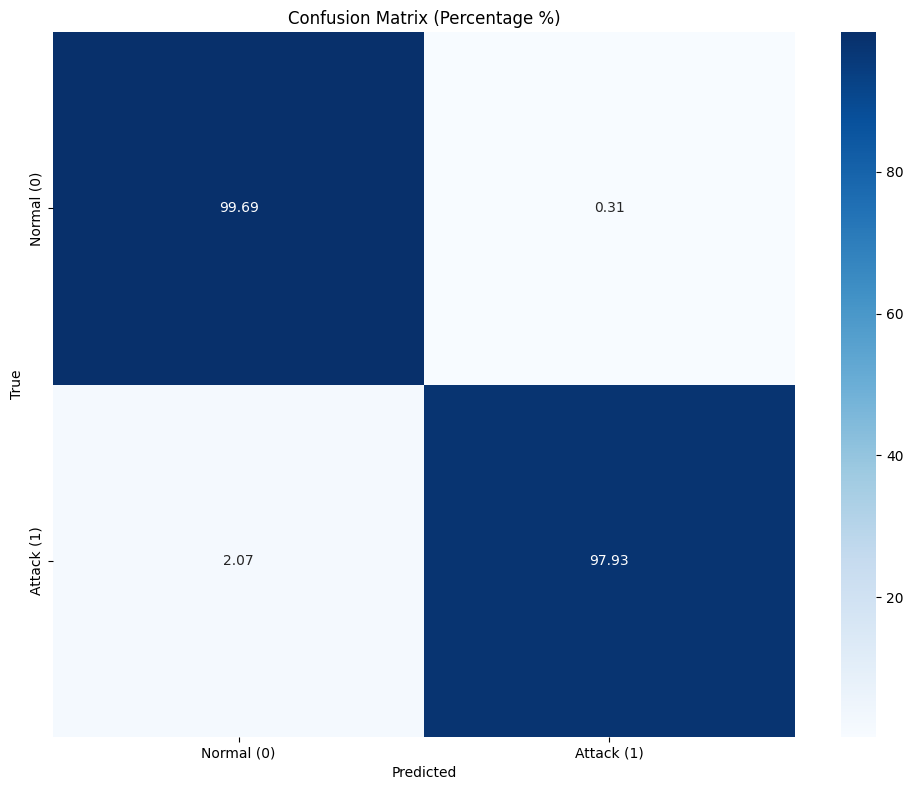

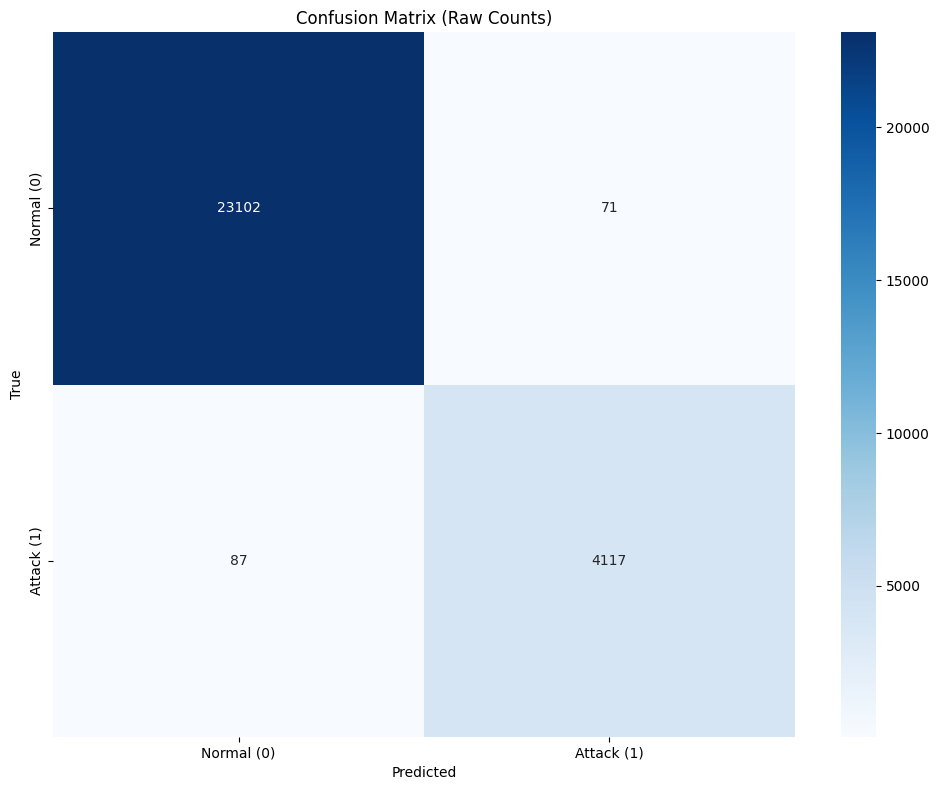

In [19]:
print("\n--- Base Model Evaluation ---")
accuracy, precision, recall, f1, per_class_accuracy, all_outputs = evaluate_model(
    default_model,
    test_loader,
    label_mapping = {'Normal': 0, 'Attack': 1},                            # Binary Classification
    # label_mapping = {'dos': 0, 'normal': 1, 'password': 2, 'scanning': 3}, # Multi-Class Classification
    save_path='default_model'
)

# **Phase 6: Hyperparameter Tuning with Optuna**

In [20]:
def objective(trial):
    """Optuna objective function for hyperparameter tuning"""
    # Get sequence length from data
    sequence_length = X_train_seq.shape[1]

    # Hyperparameters to tune
    batch_size = trial.suggest_int('batch_size', 32, 96, step=8) #32
    hidden_dim = trial.suggest_int('hidden_dim', 256, 640, step=32) #64
    num_blocks = trial.suggest_int('num_blocks', 15, 30)
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.5, log=True) # 0.1-0.5, step=0.01
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-3, log=True)
    focal_alpha = trial.suggest_float('focal_alpha', 0.25, 3.5, step=0.25) #0.25
    focal_gamma = trial.suggest_float('focal_gamma', 0.25, 3.5, step=0.25) #0.5
    use_channel_attention = trial.suggest_categorical('use_channel_attention', [True, False])
    use_temporal_attention = trial.suggest_categorical('use_temporal_attention', [True, False])
    
    if use_channel_attention or use_temporal_attention:
        attention_reduction = trial.suggest_int('attention_reduction', 8, 70, step=8)
    else:
        attention_reduction = 16  # Default value, won't be used
    
    # Create model
    num_classes = len(np.unique(y_train_seq))
    feature_dim = X_train_seq.shape[2]
    
    model = TSMixer(
        seq_len=sequence_length,  # Use seq_len to match the parameter name in TSMixer
        feat_dim=feature_dim,
        num_classes=num_classes,
        hidden_dim=hidden_dim,
        num_blocks=num_blocks,
        dropout=dropout_rate,
        use_channel_attention=use_channel_attention,
        use_temporal_attention=use_temporal_attention,
        attention_reduction=attention_reduction

    )
    model = model.to(device)
    
    # Loss function
    criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, reduction='mean')
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=False)
    
    # Create dataloaders
    train_loader, val_loader, _ = create_data_loaders(batch_size)
    
    # Train for a few epochs to evaluate performance
    num_epochs = 20
    patience = 7
    
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(num_epochs):
    
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
            
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
                
            optimizer.step()
                
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
            
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                    
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
            
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val
            
        # Update scheduler
        scheduler.step(val_loss)
            
        # Early stopping based on validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
    
    return best_val_acc  # Fixed indentation here

In [21]:
print("Starting hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=5)
)
study.optimize(objective, n_trials=15, timeout=7200)  # 2 hours max

[I 2025-04-28 19:00:29,403] A new study created in memory with name: no-name-3215e842-5720-4a51-9108-faebe0e4e4b5


Starting hyperparameter optimization...


[I 2025-04-28 19:25:41,688] Trial 0 finished with value: 0.8464769697191072 and parameters: {'batch_size': 56, 'hidden_dim': 640, 'num_blocks': 26, 'dropout_rate': 0.19843966652221853, 'learning_rate': 0.00029380279387035364, 'weight_decay': 4.207053950287931e-07, 'focal_alpha': 0.25, 'focal_gamma': 3.25, 'use_channel_attention': False, 'use_temporal_attention': False}. Best is trial 0 with value: 0.8464769697191072.
[I 2025-04-28 19:39:07,880] Trial 1 finished with value: 0.8465865507542828 and parameters: {'batch_size': 88, 'hidden_dim': 320, 'num_blocks': 17, 'dropout_rate': 0.07627364729026305, 'learning_rate': 0.0008179499475211679, 'weight_decay': 1.2561043700013547e-05, 'focal_alpha': 1.75, 'focal_gamma': 1.25, 'use_channel_attention': True, 'use_temporal_attention': False, 'attention_reduction': 32}. Best is trial 1 with value: 0.8465865507542828.
[I 2025-04-28 19:51:34,794] Trial 2 finished with value: 0.8464769697191072 and parameters: {'batch_size': 88, 'hidden_dim': 320, 'n

In [22]:
# Print optimization results

print("\nBest hyperparameters:")
best_params = study.best_params
pp.pprint(best_params)
print(f"Best validation accuracy: {study.best_value:.4f}")


Best hyperparameters:
{'attention_reduction': 32,
 'batch_size': 88,
 'dropout_rate': 0.07627364729026305,
 'focal_alpha': 1.75,
 'focal_gamma': 1.25,
 'hidden_dim': 320,
 'learning_rate': 0.0008179499475211679,
 'num_blocks': 17,
 'use_channel_attention': True,
 'use_temporal_attention': False,
 'weight_decay': 1.2561043700013547e-05}
Best validation accuracy: 0.8466


<Figure size 1200x600 with 0 Axes>

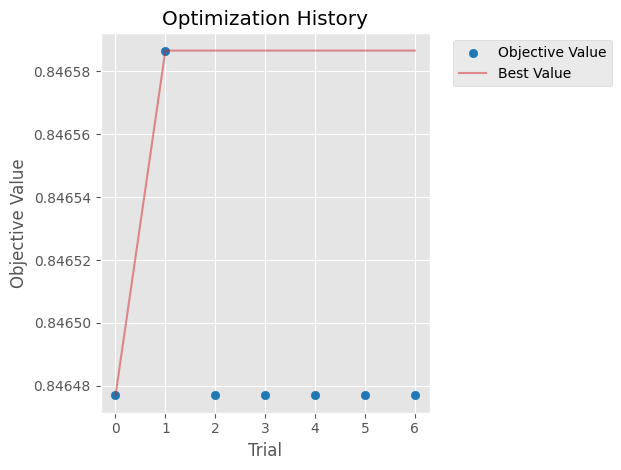

In [23]:
# Plot optimization history

plt.figure(figsize=(12, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.tight_layout()
plt.savefig('optimization_history.png')
plt.show()
plt.close()

<Figure size 1200x600 with 0 Axes>

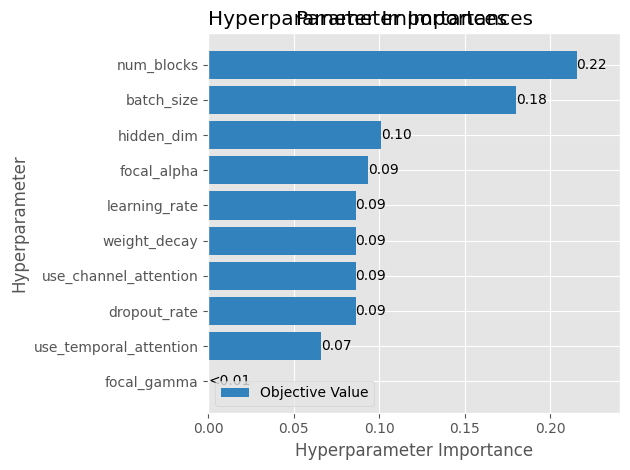

In [24]:
# Plot parameter importances

plt.figure(figsize=(12, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Parameter Importances')
plt.tight_layout()
plt.savefig('parameter_importances.png')
plt.show()
plt.close()

# **Phase 7: Train the best model**

In [25]:
best_params = study.best_params
print("\nTraining final model with best hyperparameters...")

# Create dataloaders with best batch size
train_loader, val_loader, test_loader = create_data_loaders(best_params['batch_size'])

# Create model with best hyperparameters
num_classes = len(np.unique(y_train_seq))
feature_dim = X_train_seq.shape[2]

sequence_length = X_train_seq.shape[1]

best_model = TSMixer(
    seq_len=sequence_length,  # Use seq_len to match parameter in TSMixer
    feat_dim=feature_dim,
    num_classes=num_classes,
    hidden_dim=best_params['hidden_dim'],
    num_blocks=best_params['num_blocks'],
    dropout=best_params['dropout_rate'],
    use_channel_attention=best_params['use_channel_attention'],
    use_temporal_attention=best_params['use_temporal_attention'],
    attention_reduction=best_params.get('attention_reduction', 16)
)
best_model = best_model.to(device)

# Loss function
criterion = FocalLoss(
    alpha=best_params['focal_alpha'],
    gamma=best_params['focal_gamma'],
    reduction='mean'
)

# Adam Optimizer
optimizer = optim.Adam(
    best_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Use OneCycleLR for final training
num_epochs = 30
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=best_params['learning_rate'],
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.3,
    div_factor=10.0,
    final_div_factor=100.0
)


Training final model with best hyperparameters...


In [26]:
best_model, history = train_model(
    best_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    patience=10,
    clip_value=1.0
)

Epoch 1/30 [72.8s] - Train Loss: 0.3338, Train Acc: 0.8463 - Val Loss: 0.3750, Val Acc: 0.8465
New best validation accuracy: 0.8465
Epoch 2/30 [72.8s] - Train Loss: 0.2692, Train Acc: 0.8792 - Val Loss: 0.3466, Val Acc: 0.8465
Epoch 3/30 [72.8s] - Train Loss: 0.2518, Train Acc: 0.8837 - Val Loss: 0.3365, Val Acc: 0.8465
Epoch 4/30 [73.0s] - Train Loss: 0.2454, Train Acc: 0.8852 - Val Loss: 0.3360, Val Acc: 0.8465
Epoch 5/30 [72.8s] - Train Loss: 0.2346, Train Acc: 0.8869 - Val Loss: 0.4163, Val Acc: 0.8465
Epoch 6/30 [73.0s] - Train Loss: 0.2304, Train Acc: 0.8903 - Val Loss: 0.3469, Val Acc: 0.8465
Epoch 7/30 [72.9s] - Train Loss: 0.2302, Train Acc: 0.8907 - Val Loss: 0.3427, Val Acc: 0.8465
Epoch 8/30 [73.0s] - Train Loss: 0.2229, Train Acc: 0.8928 - Val Loss: 0.3376, Val Acc: 0.8465
Epoch 9/30 [73.0s] - Train Loss: 0.2241, Train Acc: 0.8932 - Val Loss: 0.3463, Val Acc: 0.8460
Epoch 10/30 [73.0s] - Train Loss: 0.2224, Train Acc: 0.8964 - Val Loss: 0.3518, Val Acc: 0.8465
Epoch 11/30 

In [27]:
# Save the model
torch.save(best_model.state_dict(), "tsmixer_best_model.pth")

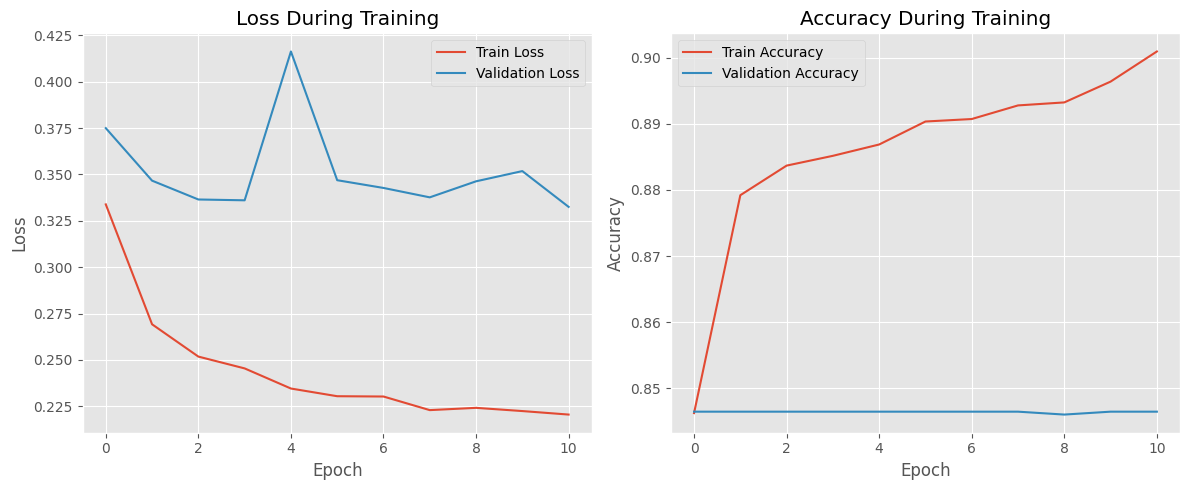

In [28]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()
plt.close()

# **Phase 8: Evaluate the final model**


--- Final Model Evaluation ---

Model Evaluation Results:
Accuracy: 0.8461
Precision: 0.7318
Recall: 0.8461
F1 Score: 0.7760

Per-class accuracy:
Class 0 (Normal): 0.9996
Class 1 (Attack): 0.0002

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.85      1.00      0.92     23173
  Attack (1)       0.10      0.00      0.00      4204

    accuracy                           0.85     27377
   macro avg       0.47      0.50      0.46     27377
weighted avg       0.73      0.85      0.78     27377



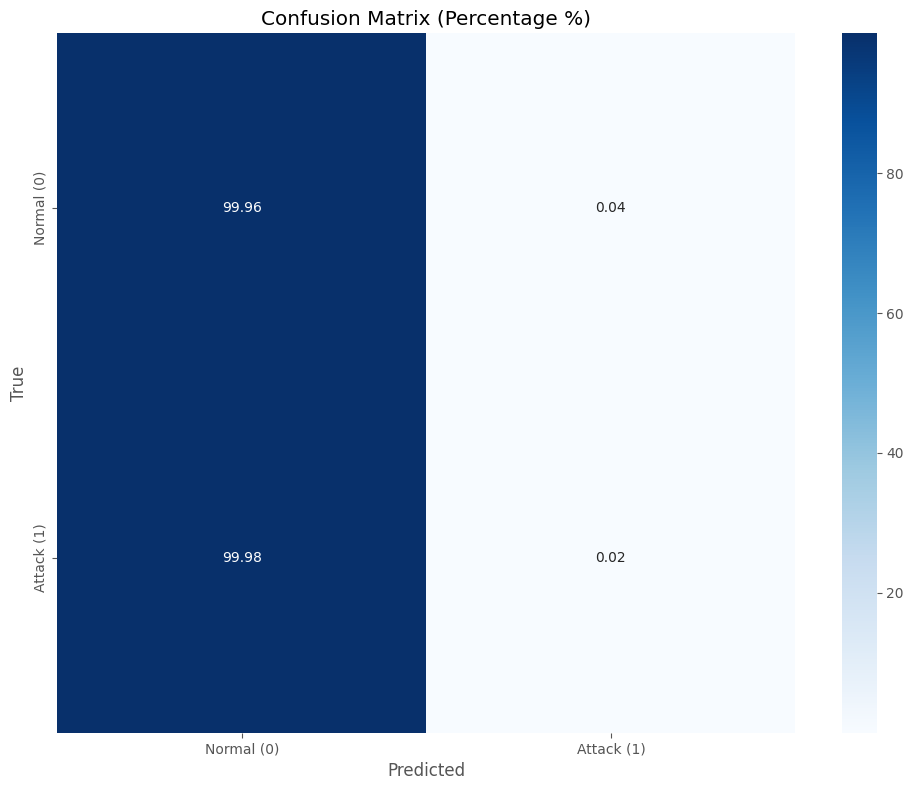

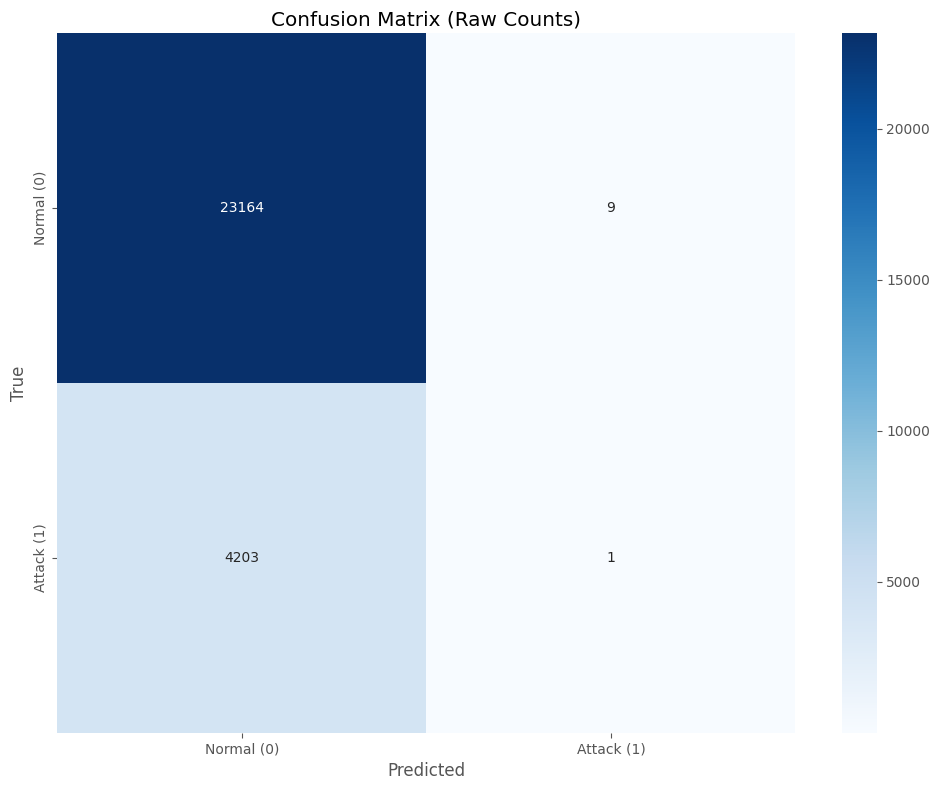

In [29]:
print("\n--- Final Model Evaluation ---")
accuracy, precision, recall, f1, per_class_accuracy, all_outputs = evaluate_model(
    best_model,
    test_loader,
    label_mapping = {'Normal': 0, 'Attack': 1},                            # Binary Classification
    # label_mapping = {'dos': 0, 'normal': 1, 'password': 2, 'scanning': 3}, # Multi-Class Classification
    save_path='final_model'
)

# **Phase 9: Explainable AI (XAI) Implementation**

In [30]:
print("\n--- Explainability Analysis with SHAP ---")

# Create a wrapper class that properly handles PyTorch model for SHAP
class ModelWrapper:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.model.eval()
        self.device = device
    
    def __call__(self, x):
        # Handle different types of input
        if isinstance(x, np.ndarray):
            x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)
        else:
            x_tensor = x.to(self.device)
        
        # Ensure model is in eval mode
        self.model.eval()
        
        # Clone tensors to avoid in-place modification issues
        with torch.no_grad():
            output = self.model(x_tensor.clone()).detach().cpu().numpy()
        
        return output

# Select a subset of test data for SHAP analysis
num_shap_samples = min(50, len(X_test_seq))  # Reduced sample size for faster computation
shap_samples = X_test_seq[:num_shap_samples]

# Ensure all operations are on CPU to avoid CUDA issues with SHAP
device = 'cpu'
best_model = best_model.to(device)

# Create background data for SHAP
background_size = min(50, len(X_train_seq))  # Use a smaller subset for background
background = X_train_seq[:background_size]

# Try different SHAP explainer approaches with proper error handling
print("Attempting SHAP analysis with different explainers...")


--- Explainability Analysis with SHAP ---
Attempting SHAP analysis with different explainers...


Trying GradientExplainer...


<Figure size 1400x1000 with 0 Axes>

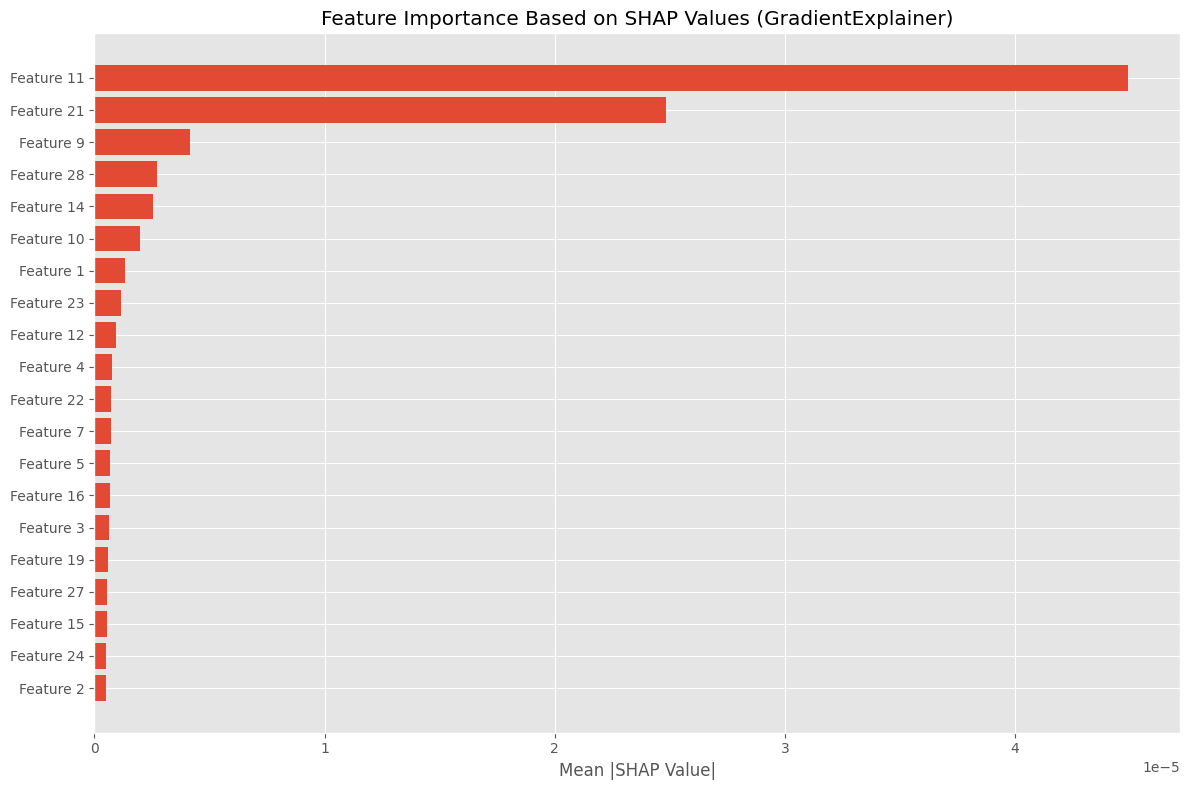

GradientExplainer analysis completed successfully.


In [31]:
# 1. First try: Use GradientExplainer which is often more stable with PyTorch
try:
    print("Trying GradientExplainer...")
    # Prepare data properly for GradientExplainer
    background_tensor = torch.tensor(background, dtype=torch.float32).to(device)
    shap_tensor = torch.tensor(shap_samples, dtype=torch.float32).to(device)
    
    # Wrap the model
    wrapped_model = ModelWrapper(best_model, device)
    
    # Create a gradient explainer
    gradient_explainer = shap.GradientExplainer(
        model=best_model,
        data=background_tensor
    )
    
    # Calculate SHAP values
    shap_values = gradient_explainer.shap_values(shap_tensor)
    
    # For classification models, shap_values will be a list of arrays (one per class)
    if isinstance(shap_values, list):
        # For visualization, we'll use the predicted class SHAP values
        with torch.no_grad():
            predictions = best_model(shap_tensor).argmax(dim=1).cpu().numpy()
        
        # Create feature importance plot (average across samples)
        plt.figure(figsize=(14, 10))
        
        # Sum absolute SHAP values across classes and features
        aggregated_shap = np.zeros((shap_samples.shape[2]))
        for class_idx in range(len(shap_values)):
            # Sum across samples and sequence length, get average importance per feature
            class_shap = np.abs(shap_values[class_idx]).mean(axis=0).mean(axis=0)
            aggregated_shap += class_shap
            
        # Sort features by importance
        feature_indices = np.argsort(-aggregated_shap)
        feature_names = [f"Feature {i}" for i in range(shap_samples.shape[2])]
        
        # Create bar plot of feature importance
        plt.figure(figsize=(12, 8))
        plt.barh(
            y=np.array(feature_names)[feature_indices[:20]], 
            width=aggregated_shap[feature_indices[:20]]
        )
        plt.title('Feature Importance Based on SHAP Values (GradientExplainer)')
        plt.xlabel('Mean |SHAP Value|')
        plt.gca().invert_yaxis()  # Display highest values at the top
        plt.tight_layout()
        plt.savefig('shap_gradient_feature_importance.png')
        plt.show()
        plt.close()
        
        print("GradientExplainer analysis completed successfully.")
    else:
        raise ValueError("Unexpected SHAP values format from GradientExplainer.")
    
except Exception as e:
    print(f"GradientExplainer failed: {str(e)}")

In [32]:
# Modified approach for DeepExplainer that avoids the view modification error
try:
    print("Trying improved DeepExplainer approach...")
    
    # Create a proper wrapper for the model
    class SHAPModelWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
            
        def forward(self, x):
            # Important: clone the input to avoid in-place modifications
            return self.model(x.clone())
    
    # Wrap the model
    wrapped_model = SHAPModelWrapper(best_model)
    wrapped_model.eval()
    
    # Convert background data properly
    background_tensor = torch.tensor(background, dtype=torch.float32).to(device)
    
    # Create DeepExplainer with wrapped model
    deep_explainer = shap.DeepExplainer(wrapped_model, background_tensor)
    
    # Get SHAP values for samples (use smaller batch if needed)
    sample_tensor = torch.tensor(shap_samples[:10], dtype=torch.float32).to(device)
    shap_values = deep_explainer.shap_values(sample_tensor)
    
    # Continue with visualization as before...
    
except Exception as e:
    print(f"Improved DeepExplainer failed: {str(e)}")
    
    # Alternative: Try KernelExplainer as a fallback
    try:
        print("Falling back to KernelExplainer...")
        
        model_wrapper = ModelWrapper(best_model, device)
        
        # Reshape data for KernelExplainer (flatten sequence dimension)
        background_flat = background.reshape(background.shape[0], -1)
        samples_flat = shap_samples.reshape(shap_samples.shape[0], -1)
        
        # Create explainer with smaller subset for speed
        kernel_explainer = shap.KernelExplainer(
            model_wrapper,
            shap.sample(background_flat, min(100, len(background_flat)))
        )
        
        # Calculate SHAP values on smaller subset for speed
        kernel_shap_values = kernel_explainer.shap_values(
            shap.sample(samples_flat, min(20, len(samples_flat)))
        )
        
        # Visualization code for KernelExplainer results
        # ...
        
    except Exception as e2:
        print(f"KernelExplainer failed: {str(e2)}")
        
        # Final fallback: Try Permutation Importance instead of SHAP
        print("Trying permutation importance as alternative to SHAP...")
        # Code for permutation importance...

Trying improved DeepExplainer approach...
Improved DeepExplainer failed: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.
Falling back to KernelExplainer...
Provided model function fails when applied to the provided data set.
KernelExplainer failed: mat1 and mat2 shapes cannot be multiplied (50x1024 and 32x320)
Trying permutation importance as alternative to SHAP...


In [33]:
# 3. Last resort: Use Permutation Importance as an alternative
try:
    print("Using permutation importance as alternative to SHAP...")
            
    from sklearn.inspection import permutation_importance
            
    # Create a function to compute model accuracy
    def model_score(X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(device)
                
        with torch.no_grad():
            outputs = best_model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == y_tensor).sum().item()
                
        return correct / len(y)
            
    # Reshape test data for permutation importance
    # We'll flatten the sequence dimension to treat each feature separately
    X_flat = X_test_seq.reshape(X_test_seq.shape[0], -1)
            
    # Compute permutation importance (this may take some time)
    perm_importance = permutation_importance(
        estimator=lambda X: np.argmax(simple_predict(X.reshape(-1, sequence_length, X_test_seq.shape[2])), axis=1),
        X=X_flat[:100],  # Use subset for speed
        y=y_test_seq[:100],
        n_repeats=5,
        random_state=42,
        n_jobs=-1
    )
            
    # Get feature importances
    importances = perm_importance.importances_mean
            
    # Group importances by original feature (since we flattened the sequence dimension)
    feature_importances = np.zeros(X_test_seq.shape[2])
    for i in range(X_test_seq.shape[2]):
        # Average importance across all timesteps for this feature
        indices = np.arange(i, X_flat.shape[1], X_test_seq.shape[2])
        feature_importances[i] = np.mean(importances[indices])
            
    # Sort and plot
    feature_indices = np.argsort(-feature_importances)
    feature_names = [f"Feature {i}" for i in range(X_test_seq.shape[2])]
            
    plt.figure(figsize=(12, 8))
    plt.barh(
        y=np.array(feature_names)[feature_indices[:20]],
        width=feature_importances[feature_indices[:20]]
    )
    plt.title('Feature Importance Based on Permutation Importance')
    plt.xlabel('Mean Accuracy Decrease')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('permutation_feature_importance.png')
    plt.show()
    plt.close()
            
    print("Permutation importance analysis completed successfully.")
            
except Exception as e:
    print(f"Permutation importance failed: {str(e)}")
    print("All explainability approaches failed. Skipping this phase.")

Using permutation importance as alternative to SHAP...
Permutation importance failed: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <function <lambda> at 0x78316223fc40> instead.
All explainability approaches failed. Skipping this phase.



--- Integrated Gradients Analysis ---
Error on sample 0: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.
Error on sample 1: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.
Error on sample 2: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. 

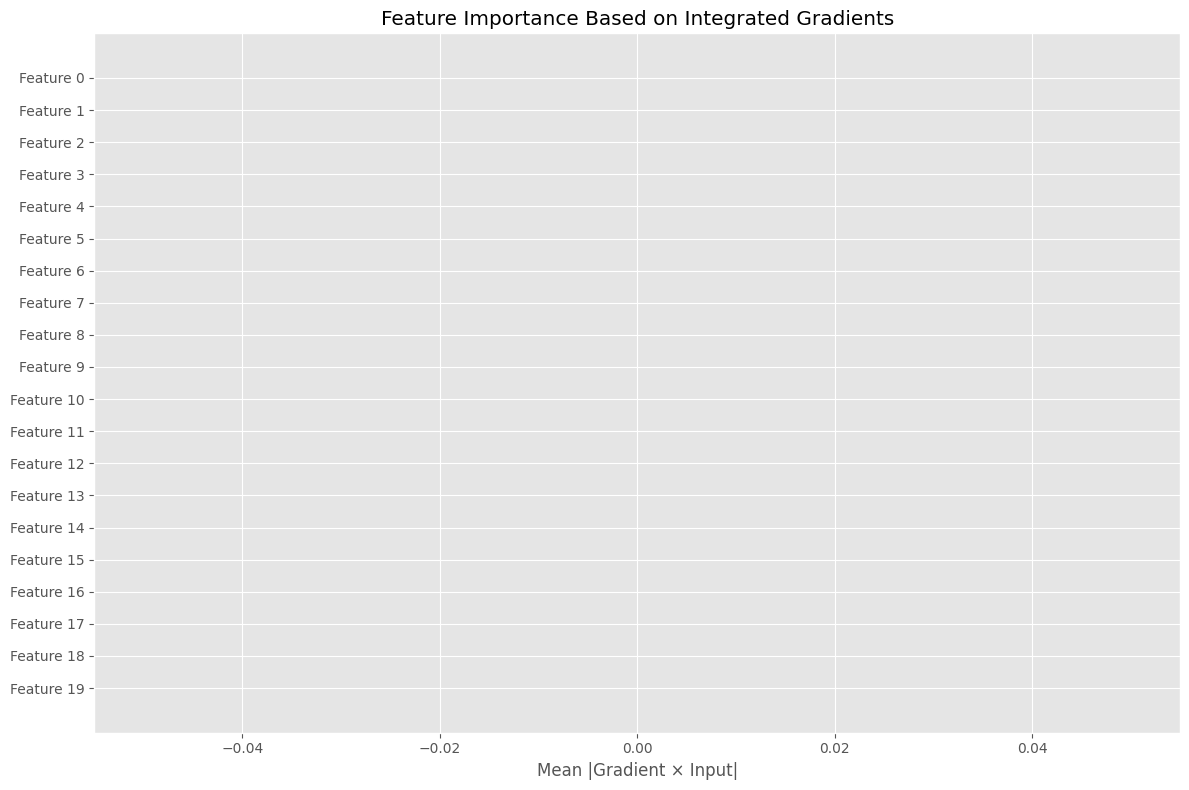

Integrated Gradients analysis completed successfully.


In [34]:
# Alternative Model Interpretation: Integrated Gradients
print("\n--- Integrated Gradients Analysis ---")

try:
    # Implement a simple integrated gradients approach for PyTorch
    def integrated_gradients(model, inputs, baseline=None, steps=50):
        # If no baseline is provided, use zeros
        if baseline is None:
            baseline = torch.zeros_like(inputs)
        
        # Prepare input for gradient calculation
        scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(steps + 1)]
        scaled_inputs = torch.cat(scaled_inputs, dim=0)
        scaled_inputs.requires_grad_(True)
        
        # Forward pass
        model.eval()
        outputs = model(scaled_inputs)
        
        # Get prediction class
        pred_class = outputs[-1].argmax().item()  # Use the last input's prediction
        
        # Compute gradients for the predicted class
        torch.autograd.grad(
            outputs=outputs[:, pred_class].sum(), 
            inputs=scaled_inputs, 
            create_graph=False, 
            retain_graph=False
        )[0]
        
        # Average gradients across steps
        avg_grads = scaled_inputs.grad.mean(dim=0)
        
        # Compute integrated gradients: (input - baseline) * avg_grads
        integrated_grads = (inputs - baseline) * avg_grads
        
        return integrated_grads, pred_class
    
    # Apply to a few test samples
    sample_inputs = torch.tensor(X_test_seq[:5], dtype=torch.float32).to(device)
    
    # Store feature importances
    feature_importances = np.zeros(X_test_seq.shape[2])
    
    for i in range(len(sample_inputs)):
        try:
            # Compute integrated gradients
            ig_attrs, pred_class = integrated_gradients(
                model=best_model,
                inputs=sample_inputs[i:i+1],
                steps=20
            )
            
            # Aggregate importance across sequence dimension
            importance = ig_attrs.abs().mean(dim=1).cpu().numpy()
            feature_importances += importance
            
            # Plot heatmap for this sample
            plt.figure(figsize=(15, 5))
            sns.heatmap(
                ig_attrs.abs().cpu().numpy().squeeze(),
                cmap='viridis',
                yticklabels=False
            )
            plt.title(f'Integrated Gradients for Sample {i+1}, Predicted Class: {pred_class}')
            plt.xlabel('Feature')
            plt.ylabel('Sequence Position')
            plt.tight_layout()
            plt.savefig(f'integrated_gradients_sample_{i+1}.png')
            plt.show()
            plt.close()
            
        except Exception as e:
            print(f"Error on sample {i}: {str(e)}")
    
    # Plot aggregated feature importance
    feature_importances = feature_importances / len(sample_inputs)
    feature_indices = np.argsort(-feature_importances)
    feature_names = [f"Feature {i}" for i in range(X_test_seq.shape[2])]
    
    plt.figure(figsize=(12, 8))
    plt.barh(
        y=np.array(feature_names)[feature_indices[:20]],
        width=feature_importances[feature_indices[:20]]
    )
    plt.title('Feature Importance Based on Integrated Gradients')
    plt.xlabel('Mean |Gradient × Input|')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('integrated_gradients_feature_importance.png')
    plt.show()
    plt.close()
    
    print("Integrated Gradients analysis completed successfully.")
    
except Exception as e:
    print(f"Integrated Gradients analysis failed: {str(e)}")

Trying feature ablation approach...


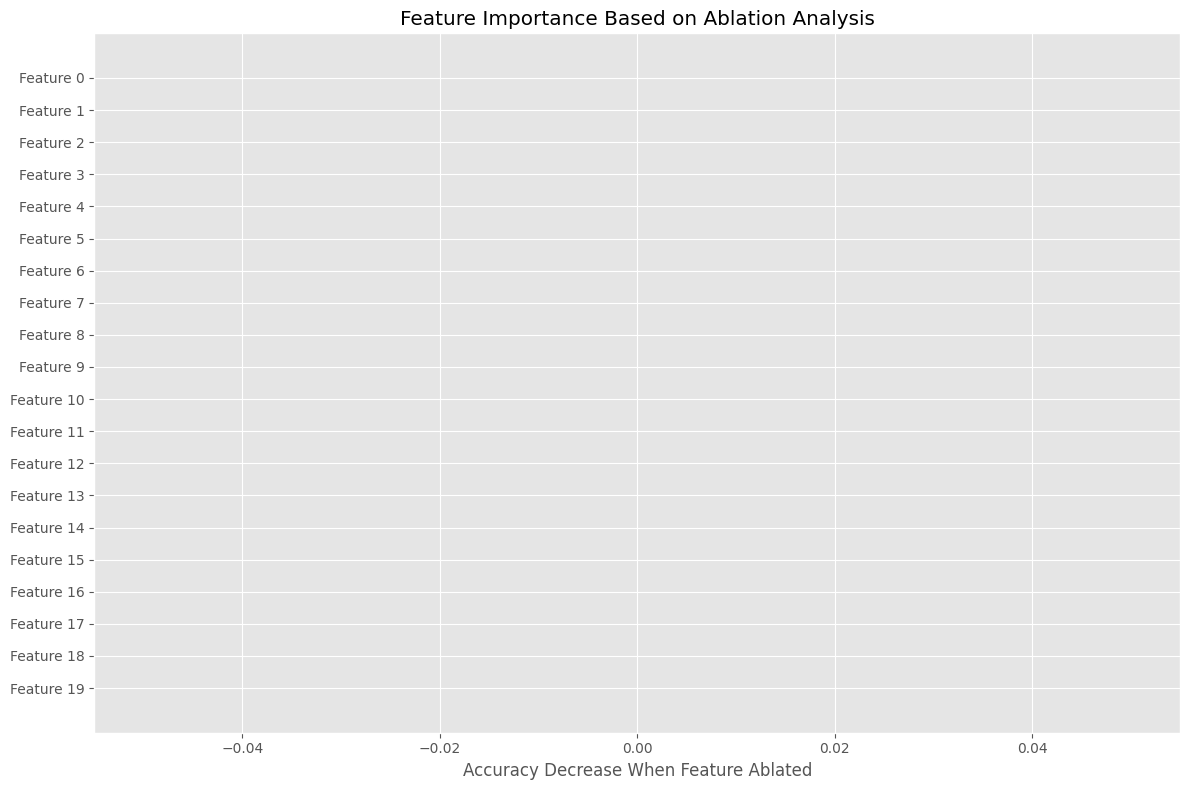

Feature ablation analysis completed successfully.


In [35]:
# As a final fallback, implement a simple feature ablation approach
try:
    print("Trying feature ablation approach...")
        
    # Function to compute model performance with ablated features
    def compute_ablation_score(model, X, y, feature_idx):
        # Create copy of data with feature zeroed out
        X_ablated = X.copy()
        X_ablated[:, :, feature_idx] = 0
            
        # Convert to tensor
        X_tensor = torch.tensor(X_ablated, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(device)
            
        # Compute predictions
        model.eval()
        with torch.no_grad():
            outputs = model(X_tensor)
            _, predictions = torch.max(outputs, 1)
            accuracy = (predictions == y_tensor).sum().item() / len(y)
            
        return accuracy
        
    # Get baseline accuracy
    X_subset = X_test_seq[:200]  # Use subset for speed
    y_subset = y_test_seq[:200]
        
    X_tensor = torch.tensor(X_subset, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_subset, dtype=torch.long).to(device)
        
    with torch.no_grad():
        outputs = best_model(X_tensor)
        _, predictions = torch.max(outputs, 1)
        baseline_accuracy = (predictions == y_tensor).sum().item() / len(y_subset)
        
    # Compute importance by ablating each feature
    feature_importances = []
    n_features = X_subset.shape[2]
        
    for i in range(n_features):
        ablated_accuracy = compute_ablation_score(best_model, X_subset, y_subset, i)
        importance = baseline_accuracy - ablated_accuracy
        feature_importances.append(importance)
        
    # Convert to numpy array
    feature_importances = np.array(feature_importances)
        
    # Plot feature importance
    feature_indices = np.argsort(-feature_importances)
    feature_names = [f"Feature {i}" for i in range(n_features)]
        
    plt.figure(figsize=(12, 8))
    plt.barh(
        y=np.array(feature_names)[feature_indices[:20]],
        width=feature_importances[feature_indices[:20]]
    )
    plt.title('Feature Importance Based on Ablation Analysis')
    plt.xlabel('Accuracy Decrease When Feature Ablated')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('ablation_feature_importance.png')
    plt.show()
    plt.close()
        
    print("Feature ablation analysis completed successfully.")
        
except Exception as e:
    print(f"Feature ablation failed: {str(e)}")
    print("All explainability methods failed. Falling back to model weight analysis only.")


--- Feature Importance from Model Weights ---


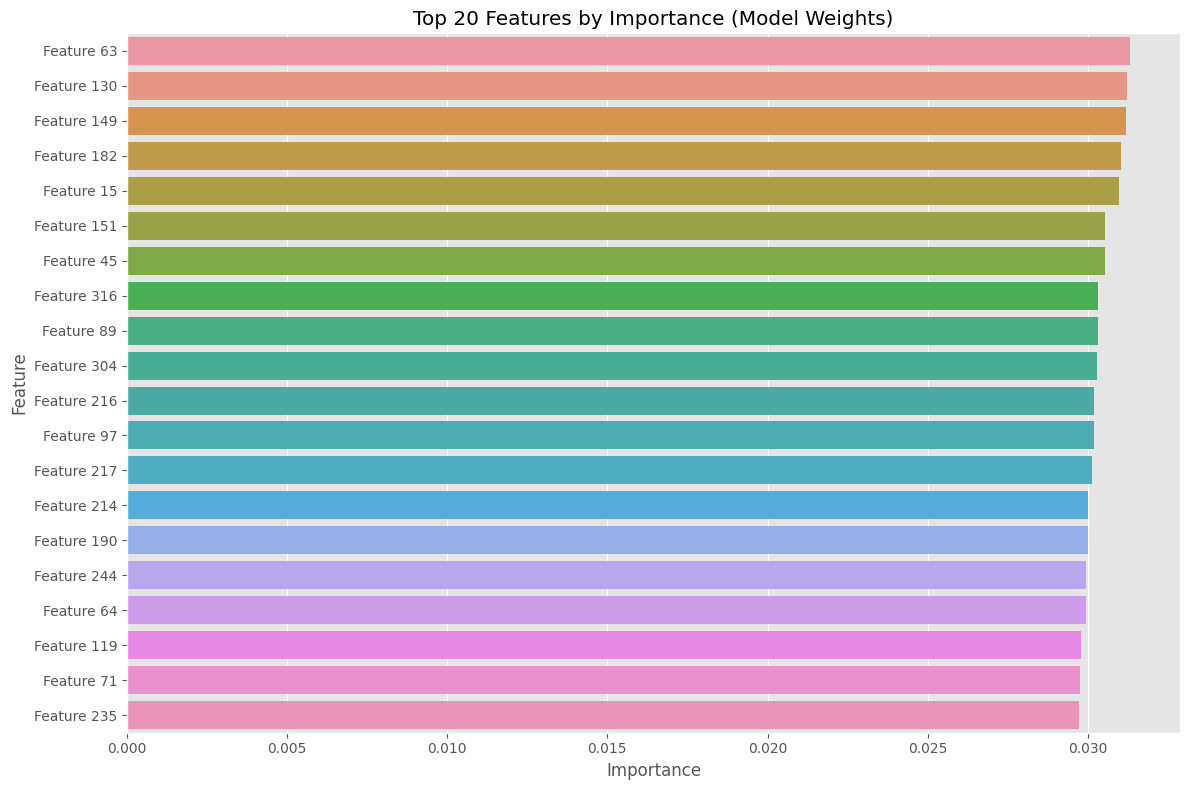

Model weight analysis completed successfully.


In [36]:
# Always run feature importance from model weights as a baseline
print("\n--- Feature Importance from Model Weights ---")

try:
    # Get the first layer weights of the classifier
    classifier_weights = best_model.classifier[0].weight.detach().cpu().numpy()
    
    # Take absolute values and average across output neurons
    feature_importance = np.abs(classifier_weights).mean(axis=0)
    
    # Map to feature names
    feature_names = [f"Feature {i}" for i in range(len(feature_importance))]
    
    # Create DataFrame for easier sorting and plotting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Features by Importance (Model Weights)')
    plt.tight_layout()
    plt.savefig('feature_importance_model_weights.png')
    plt.show()
    plt.close()
    
    print("Model weight analysis completed successfully.")
    
except Exception as e:
    print(f"Model weight analysis failed: {str(e)}")

# **Phase 10: Feature Importance Analysis**

In [37]:
print("\n--- Feature Importance Analysis ---")

# Get classifier weights from the model
def extract_feature_importance(model):
    # Extract weights from the first layer of the classifier
    classifier_weights = model.classifier[0].weight.detach().cpu().numpy()
    # Take the absolute values and average across neurons
    feature_importance = np.abs(classifier_weights).mean(axis=0)
    return feature_importance

# Extract feature importance
feature_importance = extract_feature_importance(best_model)

# Create feature names (since 'x' is not defined)
# Use generic feature names if the original DataFrame is not available
feature_names = [f"Feature_{i}" for i in range(len(feature_importance))]

# Alternatively, if you have a DataFrame with original column names somewhere in your code:
# If you used them for preprocessing earlier, you might reference that variable instead
# For example, if you have a dataframe_columns variable or can access from a scaler

# Create DataFrame with feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Features by Importance (Model Weights)')
plt.tight_layout()
plt.savefig('feature_importance_model_weights.png')
plt.close()

print("\n--- Top 20 Most Important Features ---")
print(feature_importance_df.head(20))


--- Feature Importance Analysis ---

--- Top 20 Most Important Features ---
         Feature  Importance
63    Feature_63    0.031312
130  Feature_130    0.031233
149  Feature_149    0.031185
182  Feature_182    0.031030
15    Feature_15    0.030974
151  Feature_151    0.030538
45    Feature_45    0.030534
316  Feature_316    0.030329
89    Feature_89    0.030305
304  Feature_304    0.030280
216  Feature_216    0.030199
97    Feature_97    0.030178
217  Feature_217    0.030116
214  Feature_214    0.030016
190  Feature_190    0.030005
244  Feature_244    0.029936
64    Feature_64    0.029935
119  Feature_119    0.029781
71    Feature_71    0.029765
235  Feature_235    0.029729


# **Phase 11: Create an Interpretable Visualization of the Model Architecture**

In [38]:
print("\n--- Model Architecture Visualization ---")

def visualize_model_architecture(model):
    """Create a visualization of the model architecture using Mermaid diagram syntax"""
    model_architecture = """
    graph TD
        A[Input Sequence] --> D[TSMixer]
        D --> E[MLP Classifier]
        E --> F[Output Classes]
        
        subgraph "TSMixer Core"
            D --> D1[Temporal Mixing]
            D1 --> D2[Feature Mixing]
            D2 --> D3[Layer Norm]
        end
        
        subgraph "Classifier"
            E --> E1[Linear Layers]
            E1 --> E2[Output Layer]
        end
    """
    
    # Print Mermaid syntax for diagram
    print("Model Architecture (Mermaid Diagram):")
    print(model_architecture)
    
    # Create a text summary of the model
    print("\nModel Summary:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Print model structure - safer approach that works with any model
    print("\nDetailed Model Structure:")
    print(model)
    
    # Generate simplified layer summary based on the model's structure
    print("\nSimplified Layer Summary:")
    
    # Find all Linear layers and their sizes to summarize the model structure
    linear_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            linear_layers.append(f"{name}: Linear ({module.in_features} → {module.out_features})")
    
    for i, layer_info in enumerate(linear_layers):
        print(f"Layer {i+1}: {layer_info}")

# Visualize model architecture
visualize_model_architecture(best_model)


--- Model Architecture Visualization ---
Model Architecture (Mermaid Diagram):

    graph TD
        A[Input Sequence] --> D[TSMixer]
        D --> E[MLP Classifier]
        E --> F[Output Classes]
        
        subgraph "TSMixer Core"
            D --> D1[Temporal Mixing]
            D1 --> D2[Feature Mixing]
            D2 --> D3[Layer Norm]
        end
        
        subgraph "Classifier"
            E --> E1[Linear Layers]
            E1 --> E2[Output Layer]
        end
    

Model Summary:
Total parameters: 6,029,506
Trainable parameters: 6,029,506

Detailed Model Structure:
TSMixer(
  (input_projection): Linear(in_features=32, out_features=320, bias=True)
  (mixer_blocks): ModuleList(
    (0-16): 17 x MixerBlock(
      (temporal_mlp): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.07627364729026305, inplace=False)
        (3): Linear(in_features=32, out_features=32, bias=True)
      

# **Phase 12: Conclusion and Results Summary**

In [39]:
print("\n--- Final Results Summary ---")

label_mapping = {'Normal': 0, 'Attack': 1}

summary = {
    "Model": "Enhanced TSMixer with Attention",
    "Best Hyperparameters": best_params,
    "Test Accuracy": accuracy,
    "Test Precision": precision,
    "Test Recall": recall,
    "Test F1 Score": f1,
    "Per-Class Accuracy": {next(k for k, v in label_mapping.items() if v == cls): acc 
                          for cls, acc in per_class_accuracy.items()}
}

print("Final Results Summary:")
pp.pprint(summary)

print("\nTraining completed successfully. All results and visualizations have been saved.")

# Final clean up and saving results to JSON
import json

# Convert numpy values to Python native types for JSON serialization
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.float32) or isinstance(obj, np.float64):
        return float(obj)
    elif isinstance(obj, np.int32) or isinstance(obj, np.int64):
        return int(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# Save final results
serializable_summary = convert_to_serializable(summary)
with open('final_results_summary.json', 'w') as f:
    json.dump(serializable_summary, f, indent=4)

print("\nResults saved to 'final_results_summary.json'")


--- Final Results Summary ---
Final Results Summary:
{'Best Hyperparameters': {'attention_reduction': 32,
                          'batch_size': 88,
                          'dropout_rate': 0.07627364729026305,
                          'focal_alpha': 1.75,
                          'focal_gamma': 1.25,
                          'hidden_dim': 320,
                          'learning_rate': 0.0008179499475211679,
                          'num_blocks': 17,
                          'use_channel_attention': True,
                          'use_temporal_attention': False,
                          'weight_decay': 1.2561043700013547e-05},
 'Model': 'Enhanced TSMixer with Attention',
 'Per-Class Accuracy': {'Attack': 0.0002378686964795433,
                        'Normal': 0.9996116169680231},
 'Test Accuracy': 0.8461482266135807,
 'Test F1 Score': 0.7759710371678682,
 'Test Precision': 0.7318008132172509,
 'Test Recall': 0.8461482266135807}

Training completed successfully. All results 